In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import xarray as xr
import tqdm
import utils as utils
import cartopy.crs as ccrs
from scipy.stats import ttest_ind

base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

import fit_spatial_FaIRGP as fairgp
import src.evaluation.visualisation as vis

<IPython.core.display.Javascript object>

# SSP245

In [3]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp370', 'ssp585']},}
train_data = fairgp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp245']}}
test_data = fairgp.make_data(test_cfg)

model = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp245/SpatialFaIRGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
test_scenarios = test_data.scenarios
test_tas = test_scenarios.tas

model = model.eval()
with torch.no_grad():
    posterior = model.posterior(test_scenarios, diag=False)
    posterior = model.likelihood(posterior)

In [5]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)
prior_mean = model._compute_means(test_scenarios)['ssp245']
posterior_mean = posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_correction = model.mu_targets + model.sigma_targets * posterior_mean
posterior_correction = model.beta.unsqueeze(0) * posterior_correction
posterior_mean = prior_mean + posterior_correction

posterior_stddev = posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_stddev = model.sigma_targets * posterior_stddev * torch.abs(model.beta.unsqueeze(0))
posterior_ub = posterior_mean + 2 * posterior_stddev
posterior_lb = posterior_mean - 2 * posterior_stddev

In [11]:
def encapsulate_as_xarray(data, scenario):
    field = xr.DataArray(data=data.cpu(),
                         dims=['time', 'lat', 'lon'],
                         coords=dict(time=scenario.timesteps.cpu(),
                                     lat=scenario.lat.cpu(),
                                     lon=scenario.lon.cpu()))
    return field

encapsulate = lambda data: encapsulate_as_xarray(data, test_scenarios[0])
xr_prior_mean = encapsulate(prior_mean)
xr_posterior_correction = encapsulate(posterior_correction)
xr_posterior_mean = encapsulate(posterior_mean)
xr_posterior_ub = encapsulate(posterior_ub)
xr_posterior_lb = encapsulate(posterior_lb)
xr_groundtruth = encapsulate(test_tas)

In [12]:
start, end = 2080, 2100
time_slice = slice(start, end)

xr_prior_mean = xr_prior_mean.sel(time=time_slice).mean(dim='time')
xr_correction = xr_posterior_correction.sel(time=time_slice).mean(dim='time')
xr_posterior_mean = xr_posterior_mean.sel(time=time_slice).mean(dim='time')
xr_posterior_ub = xr_posterior_ub.sel(time=time_slice).mean(dim='time')
xr_posterior_lb = xr_posterior_lb.sel(time=time_slice).mean(dim='time')
xr_groundtruth = xr_groundtruth.sel(time=time_slice).mean(dim='time')

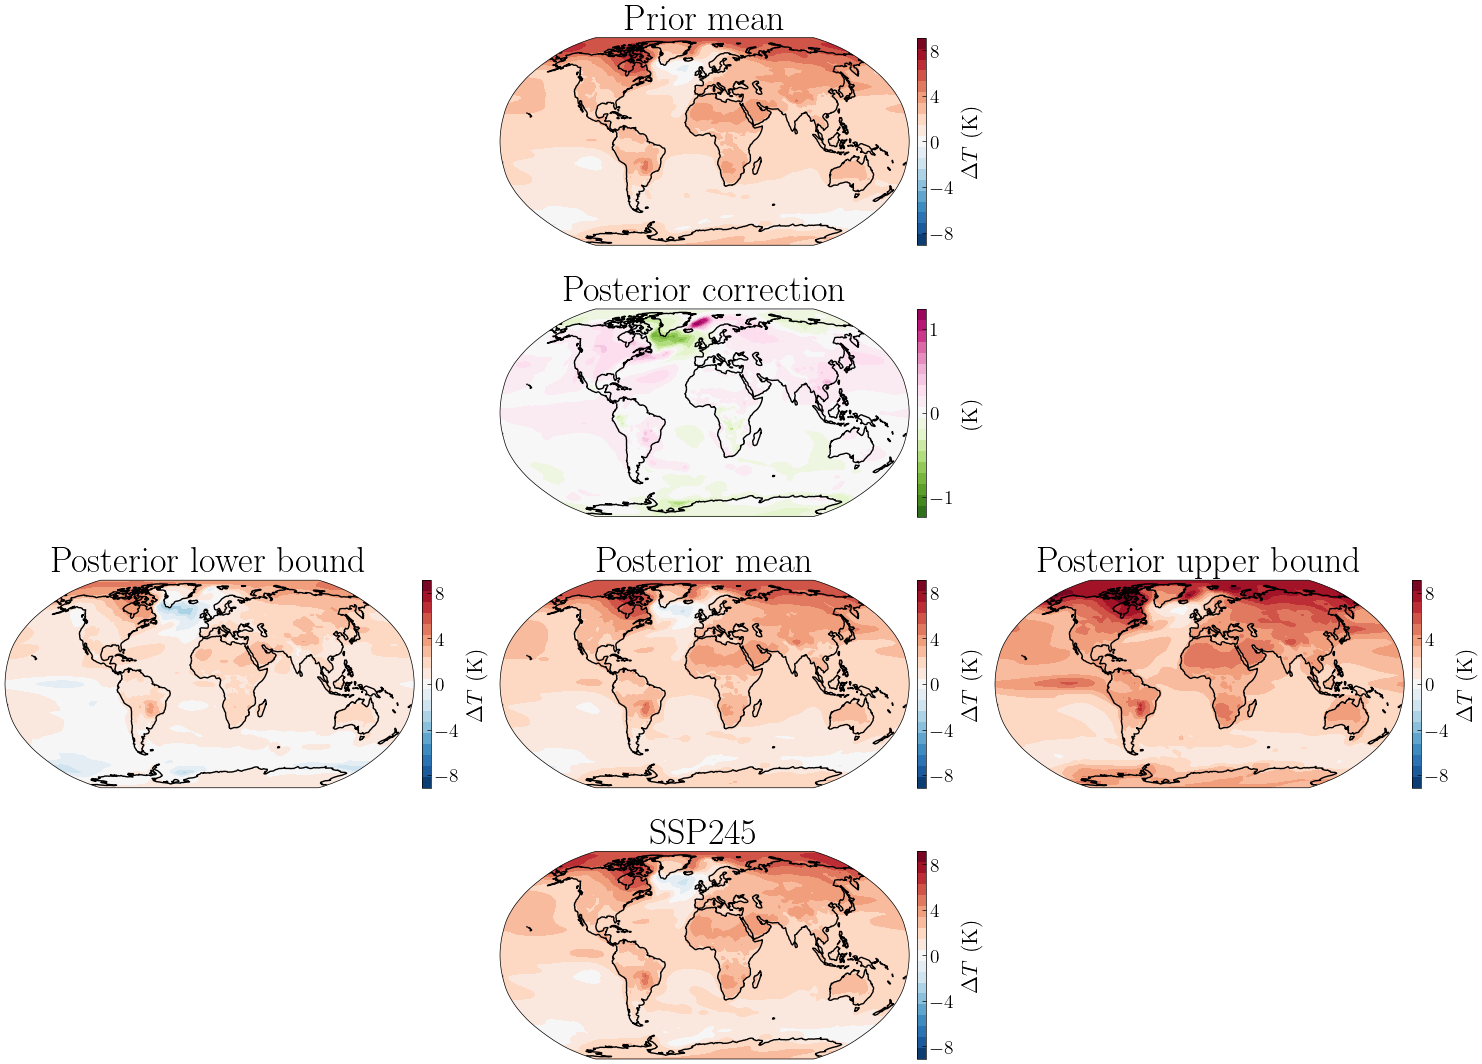

In [26]:
fig, ax = plt.subplots(4, 3, figsize=(15, 11), subplot_kw={'projection': ccrs.Robinson()})

for i in [0, 1, 3]:
    ax[i, 0].remove()
    ax[i, 2].remove()
    
vmax = max(np.abs(xr_posterior_ub.data).max(), np.abs(xr_posterior_lb.data).max(), np.abs(xr_groundtruth.data).max())

_, __, cbar_prior_mean = vis.plot_contourf_on_ax(xr_prior_mean, fig, ax[0, 1], title="Prior mean", vmax=vmax, colorbar=True, fontsize=20)
_, __, cbar_correction = vis.plot_contourf_on_ax(xr_correction, fig, ax[1, 1], title="Posterior correction", colorbar=True, cmap='PiYG_r', fontsize=20)
_, __, cbar_posterior_ub = vis.plot_contourf_on_ax(xr_posterior_ub, fig, ax[2, 2], title="Posterior upper bound", vmax=vmax, colorbar=True, fontsize=20)
_, __, cbar_posterior_mean = vis.plot_contourf_on_ax(xr_posterior_mean, fig, ax[2, 1], title="Posterior mean", vmax=vmax, colorbar=True, fontsize=20)
_, __, cbar_posterior_lb = vis.plot_contourf_on_ax(xr_posterior_lb, fig, ax[2, 0], title="Posterior lower bound", vmax=vmax, colorbar=True, fontsize=20)
_, __, cbar_groundtruth = vis.plot_contourf_on_ax(xr_groundtruth, fig, ax[3, 1], title="Groundtruth", vmax=vmax, colorbar=True, fontsize=20)
cbars = (cbar_prior_mean, cbar_correction, cbar_posterior_mean, cbar_posterior_lb, cbar_posterior_ub, cbar_groundtruth)

cbar_fontsize = 18
ticks = [-8, -4, 0, 4, 8]

for i, c in enumerate(cbars):
    if i == 1:
        continue
    c.set_ticks(ticks)
    c.ax.tick_params(labelsize=14)
    c.set_label(r'$\Delta T$ (K)', fontsize=16)
cbars[1].set_label('(K)', fontsize=16)
cbars[1].set_ticks([-1, 0, 1])
cbars[1].ax.tick_params(labelsize=14)


ax[0, 1].set_title("Prior mean", fontsize=26)
ax[1, 1].set_title("Posterior correction", fontsize=26)
ax[2, 2].set_title("Posterior upper bound", fontsize=26)
ax[2, 1].set_title("Posterior mean", fontsize=26)
ax[2, 0].set_title("Posterior lower bound", fontsize=26)
ax[3, 1].set_title("SSP245", fontsize=26)

plt.tight_layout()
plt.savefig('./figures/SSP245-spatial-prediction-FaIRGP-paper-plot.jpg', dpi=200)
plt.show()

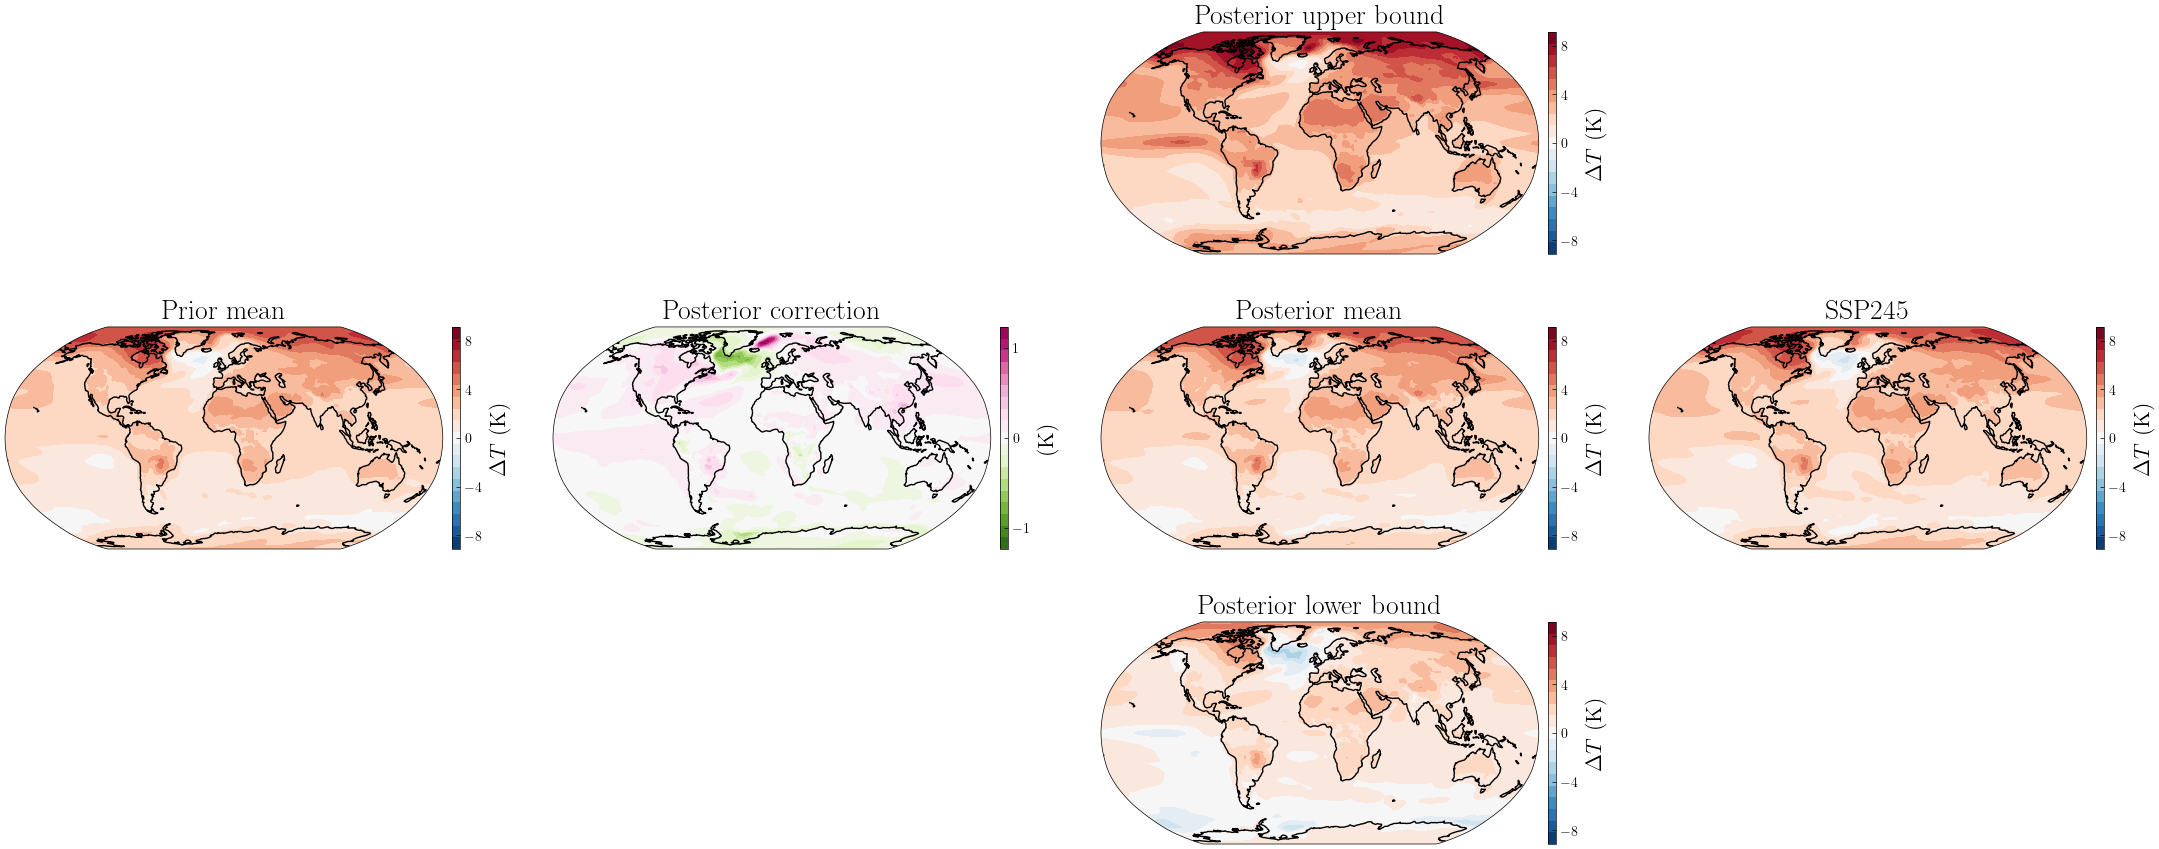

In [7]:
start, end = 2080, 2100
time_slice = slice(start, end)

fig, ax, cbars = vis.plot_tryptych(xr_prior_mean.sel(time=time_slice).mean(dim='time'),
                                xr_posterior_correction.sel(time=time_slice).mean(dim='time'),
                                xr_posterior_mean.sel(time=time_slice).mean(dim='time'),
                                xr_posterior_ub.sel(time=time_slice).mean(dim='time'),
                                xr_posterior_lb.sel(time=time_slice).mean(dim='time'),
                                xr_groundtruth.sel(time=time_slice).mean(dim='time'))

cbar_fontsize = 18
ticks = [-8, -4, 0, 4, 8]

for i, c in enumerate(cbars):
    if i == 1:
        continue
    c.set_ticks(ticks)
    c.set_label(r'$\Delta T$ (K)', fontsize=16)
cbars[1].set_label('(K)', fontsize=16)
cbars[1].set_ticks([-1, 0, 1])

ax[1, 0].set_title("Prior mean", fontsize=20)
ax[1, 1].set_title("Posterior correction", fontsize=20)
ax[0, 2].set_title("Posterior upper bound", fontsize=20)
ax[1, 2].set_title("Posterior mean", fontsize=20)
ax[2, 2].set_title("Posterior lower bound", fontsize=20)
ax[1, 3].set_title("SSP245", fontsize=20)

# plt.savefig('./figures/SSP245-spatial-prediction-FaIRGP.png', dpi=300)

plt.show()

In [8]:
# Compute mean bias
mean_bias = posterior_mean - test_tas
xr_bias = encapsulate(mean_bias).sel(time=time_slice)

# Run t-test to identify insignificant differences
slice_posterior_mean = xr_posterior_mean.sel(time=time_slice).values.reshape(21, -1)
slice_groundtruth = xr_groundtruth.sel(time=time_slice).values.reshape(21, -1)
pvalues = ttest_ind(slice_posterior_mean, slice_groundtruth).pvalue
insignificant = (pvalues < 0.05).astype(int).reshape(96, 144)
xr_insignificant = xr.DataArray(data=insignificant,
                         dims=['lat', 'lon'],
                         coords=dict(lat=xr_bias.lat,
                                     lon=xr_bias.lon))

# Set to zero insignificant biases
xr_bias = xr_bias * xr_insignificant

# Create is in CR xarray
is_in_CR = (test_tas >= posterior_lb) & (test_tas <= posterior_ub)
xr_isin_CR = encapsulate(is_in_CR.int())

# Save xarrays
# xr_bias.to_netcdf('./netcdf/bias-ssp245-FaIRGP.nc')
# xr_isin_CR.to_netcdf('./netcdf/isinCR-ssp245-FaIRGP.nc')

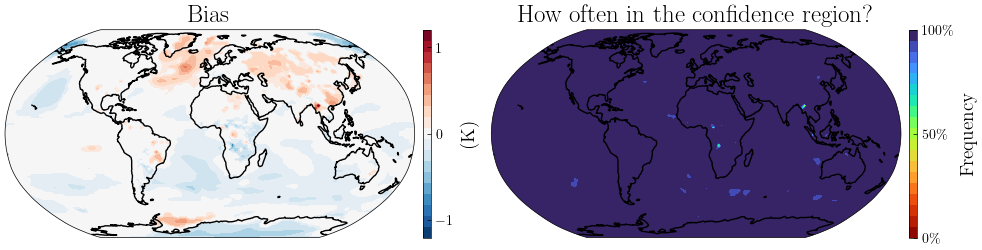

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': ccrs.Robinson()})

idx = 35

_, __, cbar = vis.plot_contourf_on_ax(xr_bias.sel(time=time_slice).mean(dim='time'), 
                                      fig, ax[0], colorbar=True)
cbar.set_label('(K)', fontsize=14)
cbar.set_ticks([-1, 0, 1])

_, __, cbar = vis.plot_contourf_on_ax(xr_isin_CR.sel(time=time_slice).mean(dim='time'), 
                                      fig, ax[1], 
                                      colorbar=True, vmin=0, vmax=1., cmap='turbo_r')
cbar.set_label('Frequency', fontsize=14)
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['0\%', '50\%', '100\%'])

ax[0].set_title("Bias", fontsize=18)
ax[1].set_title("How often in the confidence region?", fontsize=18)

plt.tight_layout()

# plt.savefig('./figures/SSP245-spatial-comparison-FaIRGP.png', dpi=300)
plt.show()

# SSP126

In [10]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp245', 'ssp370', 'ssp585']}}
train_data = fairgp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp126']}}
test_data = fairgp.make_data(test_cfg)

model = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp126/SpatialFaIRGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
test_scenarios = test_data.scenarios
test_tas = test_scenarios.tas

model = model.eval()
with torch.no_grad():
    posterior = model.posterior(test_scenarios, diag=False)
    posterior = model.likelihood(posterior)

In [12]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)
prior_mean = model._compute_means(test_scenarios)['ssp126']
posterior_mean = posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_correction = model.mu_targets + model.sigma_targets * posterior_mean
posterior_correction = model.beta.unsqueeze(0) * posterior_correction
posterior_mean = prior_mean + posterior_correction

posterior_stddev = posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_stddev = model.sigma_targets * posterior_stddev * torch.abs(model.beta.unsqueeze(0))
posterior_ub = posterior_mean + 2 * posterior_stddev
posterior_lb = posterior_mean - 2 * posterior_stddev

In [13]:
def encapsulate_as_xarray(data, scenario):
    field = xr.DataArray(data=data.cpu(),
                         dims=['time', 'lat', 'lon'],
                         coords=dict(time=scenario.timesteps.cpu(),
                                     lat=scenario.lat.cpu(),
                                     lon=scenario.lon.cpu()))
    return field

encapsulate = lambda data: encapsulate_as_xarray(data, test_scenarios[0])
xr_prior_mean = encapsulate(prior_mean)
xr_posterior_correction = encapsulate(posterior_correction)
xr_posterior_mean = encapsulate(posterior_mean)
xr_posterior_ub = encapsulate(posterior_ub)
xr_posterior_lb = encapsulate(posterior_lb)
xr_groundtruth = encapsulate(test_tas)

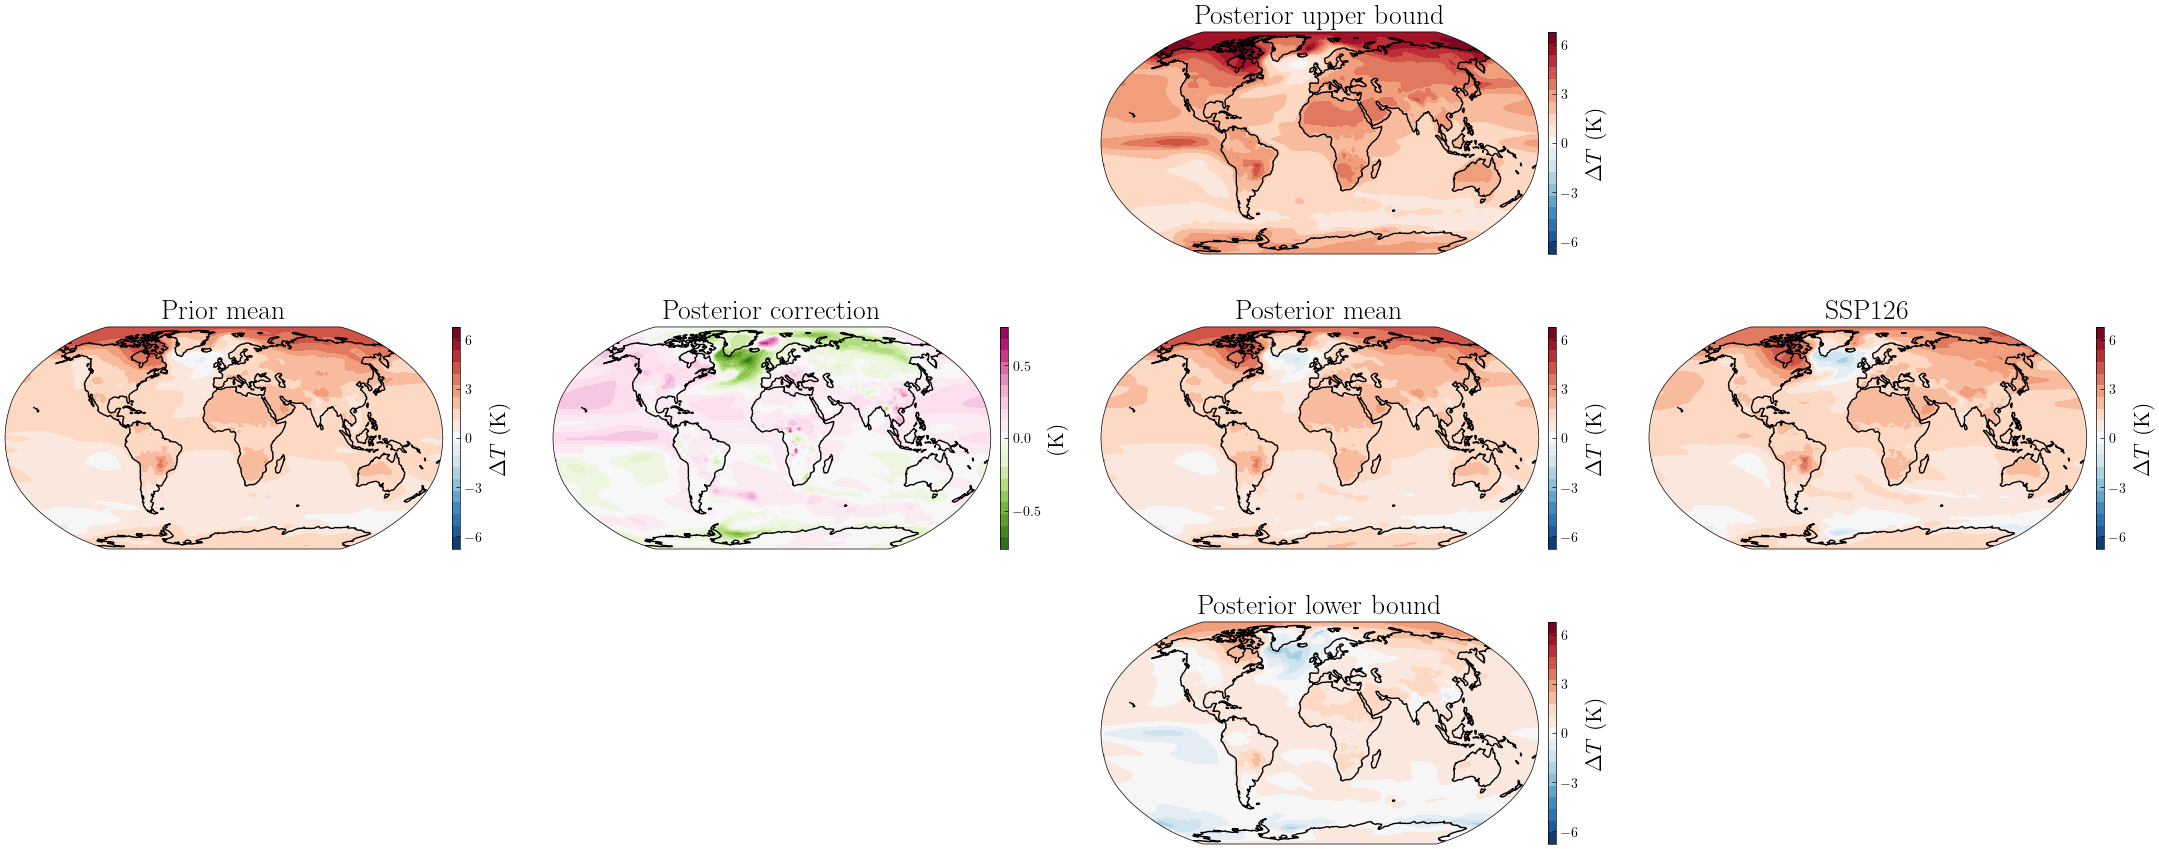

In [14]:
start, end = 2080, 2100
time_slice = slice(start, end)

fig, ax, cbars = vis.plot_tryptych(xr_prior_mean.sel(time=time_slice).mean(dim='time'),
                                xr_posterior_correction.sel(time=time_slice).mean(dim='time'),
                                xr_posterior_mean.sel(time=time_slice).mean(dim='time'),
                                xr_posterior_ub.sel(time=time_slice).mean(dim='time'),
                                xr_posterior_lb.sel(time=time_slice).mean(dim='time'),
                                xr_groundtruth.sel(time=time_slice).mean(dim='time'))

cbar_fontsize = 18
ticks = [-6, -3, 0, 3, 6]

for i, c in enumerate(cbars):
    if i == 1:
        continue
    c.set_ticks(ticks)
    c.set_label(r'$\Delta T$ (K)', fontsize=16)
cbars[1].set_label('(K)', fontsize=16)
cbars[1].set_ticks([-0.5, 0, 0.5])

ax[1, 0].set_title("Prior mean", fontsize=20)
ax[1, 1].set_title("Posterior correction", fontsize=20)
ax[0, 2].set_title("Posterior upper bound", fontsize=20)
ax[1, 2].set_title("Posterior mean", fontsize=20)
ax[2, 2].set_title("Posterior lower bound", fontsize=20)
ax[1, 3].set_title("SSP126", fontsize=20)

# plt.savefig('./figures/SSP126-spatial-prediction-FaIRGP.png', dpi=300)

plt.show()

In [15]:
# Compute mean bias
mean_bias = posterior_mean - test_tas
xr_bias = encapsulate(mean_bias).sel(time=time_slice)

# Run t-test to identify insignificant differences
slice_posterior_mean = xr_posterior_mean.sel(time=time_slice).values.reshape(21, -1)
slice_groundtruth = xr_groundtruth.sel(time=time_slice).values.reshape(21, -1)
pvalues = ttest_ind(slice_posterior_mean, slice_groundtruth).pvalue
insignificant = (pvalues < 0.05).astype(int).reshape(96, 144)
xr_insignificant = xr.DataArray(data=insignificant,
                         dims=['lat', 'lon'],
                         coords=dict(lat=xr_bias.lat,
                                     lon=xr_bias.lon))

# Set to zero insignificant biases
xr_bias = xr_bias * xr_insignificant

# Create is in CR xarray
is_in_CR = (test_tas >= posterior_lb) & (test_tas <= posterior_ub)
xr_isin_CR = encapsulate(is_in_CR.int())

# Save xarrays
# xr_bias.to_netcdf('./netcdf/bias-ssp126-FaIRGP.nc')
# xr_isin_CR.to_netcdf('./netcdf/isinCR-ssp126-FaIRGP.nc')

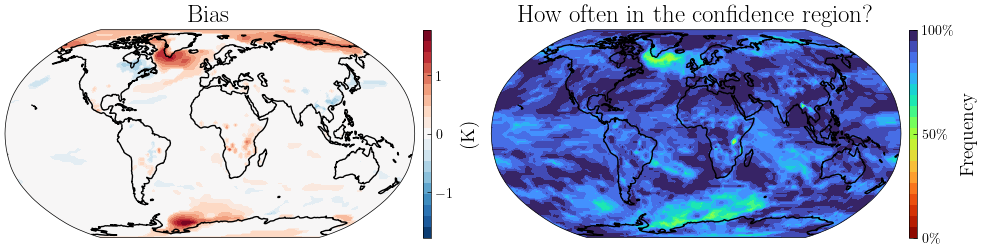

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': ccrs.Robinson()})

idx = 35

_, __, cbar = vis.plot_contourf_on_ax(xr_bias.sel(time=time_slice).mean(dim='time'), 
                                      fig, ax[0], colorbar=True)
cbar.set_label('(K)', fontsize=14)
cbar.set_ticks([-1, 0, 1])

_, __, cbar = vis.plot_contourf_on_ax(xr_isin_CR.sel(time=time_slice).mean(dim='time'), 
                                      fig, ax[1], 
                                      colorbar=True, vmin=0, vmax=1., cmap='turbo_r')
cbar.set_label('Frequency', fontsize=14)
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['0\%', '50\%', '100\%'])

ax[0].set_title("Bias", fontsize=18)
ax[1].set_title("How often in the confidence region?", fontsize=18)

plt.tight_layout()

# plt.savefig('./figures/SSP126-spatial-comparison-FaIRGP.png', dpi=300)
plt.show()

# SSP585

In [17]:
train_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['historical', 'ssp126', 'ssp245', 'ssp370']}}
train_data = fairgp.make_data(train_cfg)

test_cfg = {'dataset' : {'dirpath': '../data/', 'keys': ['ssp585']}}
test_data = fairgp.make_data(test_cfg)

model = fairgp.make_model(train_cfg, train_data)
state_dict = torch.load('../data/models/leave-one-out-ssp/ssp585/SpatialFaIRGP/state_dict.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
test_scenarios = test_data.scenarios
test_tas = test_scenarios.tas

model = model.eval()
with torch.no_grad():
    posterior = model.posterior(test_scenarios, diag=False)
    posterior = model.likelihood(posterior)

In [19]:
nlat = len(test_scenarios[0].lat)
nlon = len(test_scenarios[0].lon)
prior_mean = model._compute_means(test_scenarios)['ssp585']
posterior_mean = posterior.mean.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_correction = model.mu_targets + model.sigma_targets * posterior_mean
posterior_correction = model.beta.unsqueeze(0) * posterior_correction
posterior_mean = prior_mean + posterior_correction

posterior_stddev = posterior.stddev.reshape(nlat, nlon, -1).permute(2, 0, 1)
posterior_stddev = model.sigma_targets * posterior_stddev * torch.abs(model.beta.unsqueeze(0))
posterior_ub = posterior_mean + 2 * posterior_stddev
posterior_lb = posterior_mean - 2 * posterior_stddev

In [20]:
def encapsulate_as_xarray(data, scenario):
    field = xr.DataArray(data=data.cpu(),
                         dims=['time', 'lat', 'lon'],
                         coords=dict(time=scenario.timesteps.cpu(),
                                     lat=scenario.lat.cpu(),
                                     lon=scenario.lon.cpu()))
    return field

encapsulate = lambda data: encapsulate_as_xarray(data, test_scenarios[0])
xr_prior_mean = encapsulate(prior_mean)
xr_posterior_correction = encapsulate(posterior_correction)
xr_posterior_mean = encapsulate(posterior_mean)
xr_posterior_ub = encapsulate(posterior_ub)
xr_posterior_lb = encapsulate(posterior_lb)
xr_groundtruth = encapsulate(test_tas)

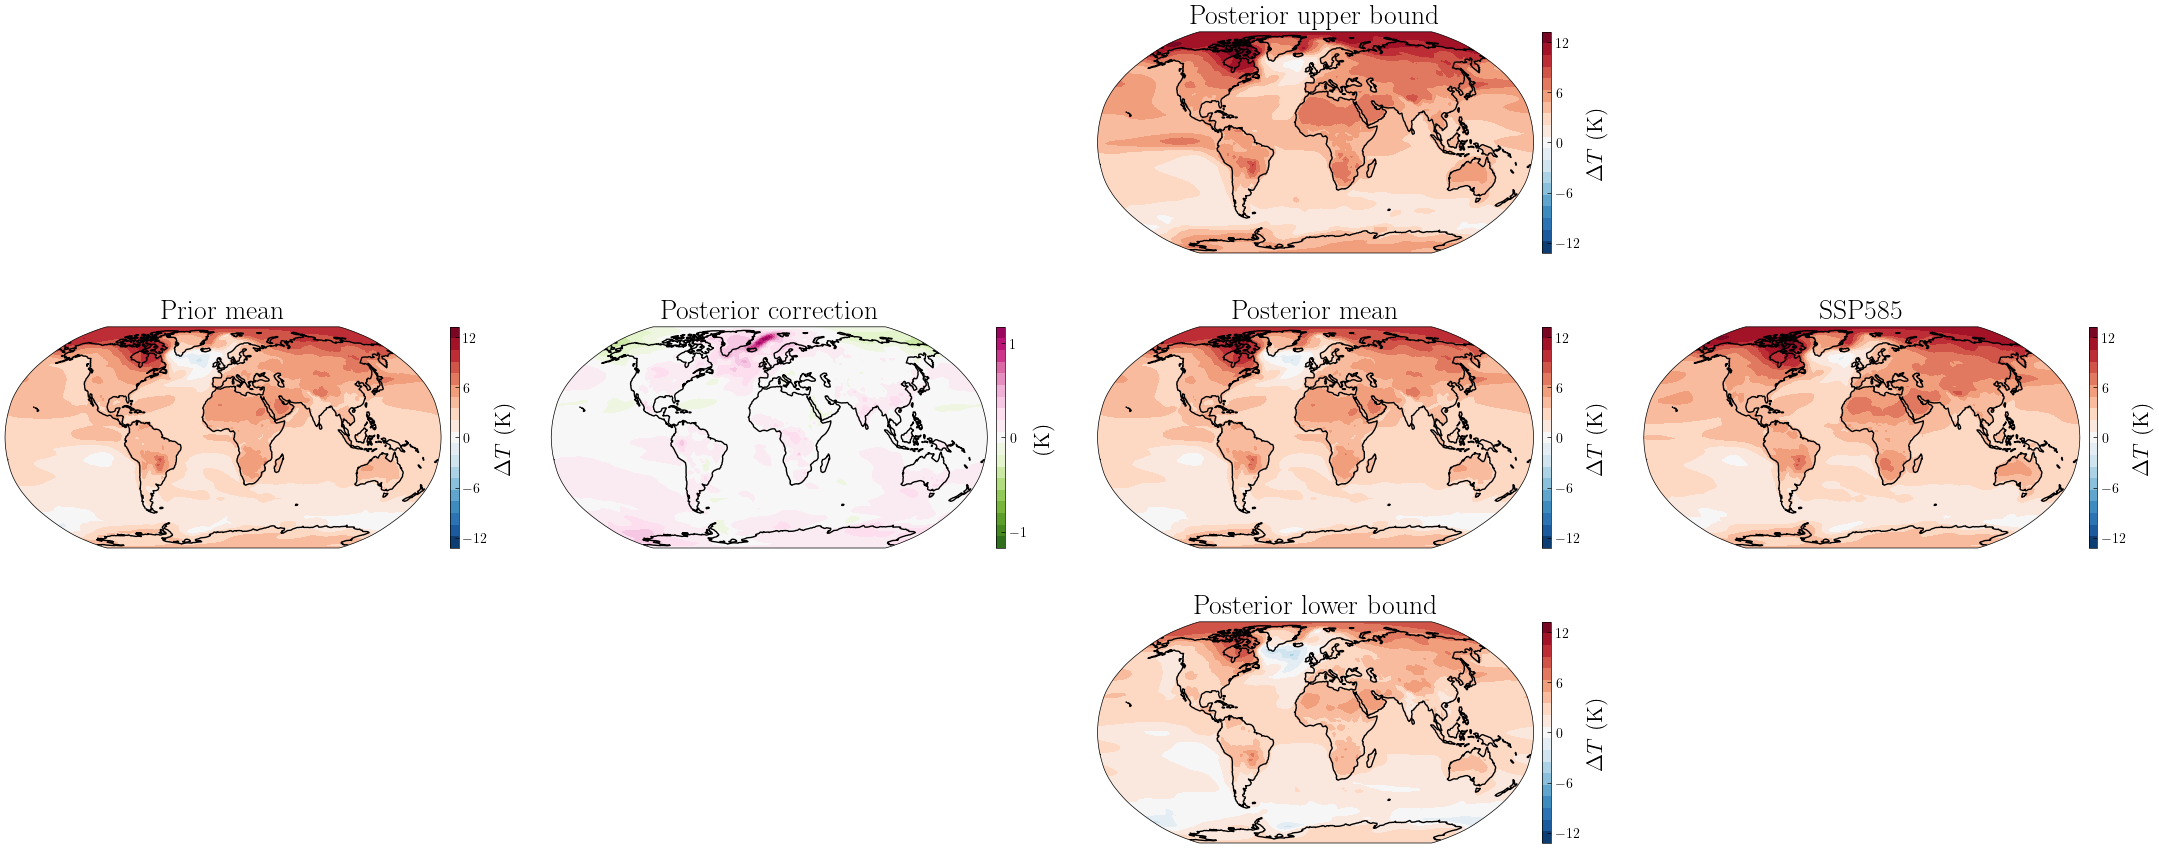

In [22]:
start, end = 2080, 2100
time_slice = slice(start, end)

fig, ax, cbars = vis.plot_tryptych(xr_prior_mean.sel(time=time_slice).mean(dim='time'),
                                xr_posterior_correction.sel(time=time_slice).mean(dim='time'),
                                xr_posterior_mean.sel(time=time_slice).mean(dim='time'),
                                xr_posterior_ub.sel(time=time_slice).mean(dim='time'),
                                xr_posterior_lb.sel(time=time_slice).mean(dim='time'),
                                xr_groundtruth.sel(time=time_slice).mean(dim='time'))

cbar_fontsize = 18
ticks = [-12, -6, 0, 6, 12]

for i, c in enumerate(cbars):
    if i == 1:
        continue
    c.set_ticks(ticks)
    c.set_label(r'$\Delta T$ (K)', fontsize=16)
cbars[1].set_label('(K)', fontsize=16)
cbars[1].set_ticks([-1, 0, 1])

ax[1, 0].set_title("Prior mean", fontsize=20)
ax[1, 1].set_title("Posterior correction", fontsize=20)
ax[0, 2].set_title("Posterior upper bound", fontsize=20)
ax[1, 2].set_title("Posterior mean", fontsize=20)
ax[2, 2].set_title("Posterior lower bound", fontsize=20)
ax[1, 3].set_title("SSP585", fontsize=20)

plt.savefig('./figures/SSP585-spatial-prediction-FaIRGP.png', dpi=300)

plt.show()

In [23]:
# Compute mean bias
mean_bias = posterior_mean - test_tas
xr_bias = encapsulate(mean_bias).sel(time=time_slice)

# Run t-test to identify insignificant differences
slice_posterior_mean = xr_posterior_mean.sel(time=time_slice).values.reshape(21, -1)
slice_groundtruth = xr_groundtruth.sel(time=time_slice).values.reshape(21, -1)
pvalues = ttest_ind(slice_posterior_mean, slice_groundtruth).pvalue
insignificant = (pvalues < 0.05).astype(int).reshape(96, 144)
xr_insignificant = xr.DataArray(data=insignificant,
                         dims=['lat', 'lon'],
                         coords=dict(lat=xr_bias.lat,
                                     lon=xr_bias.lon))

# Set to zero insignificant biases
xr_bias = xr_bias * xr_insignificant

# Create is in CR xarray
is_in_CR = (test_tas >= posterior_lb) & (test_tas <= posterior_ub)
xr_isin_CR = encapsulate(is_in_CR.int())

# Save xarrays
# xr_bias.to_netcdf('./netcdf/bias-ssp585-FaIRGP.nc')
# xr_isin_CR.to_netcdf('./netcdf/isinCR-ssp585-FaIRGP.nc')

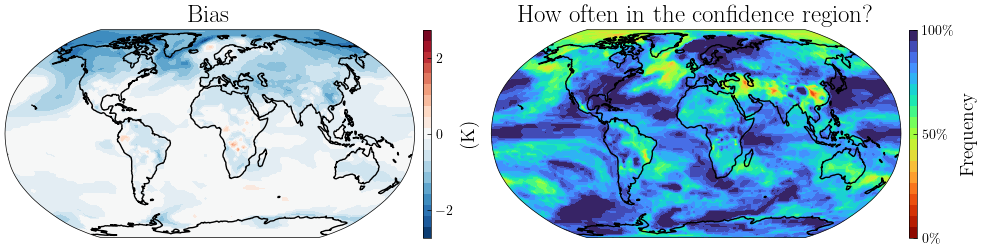

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': ccrs.Robinson()})

idx = 35

_, __, cbar = vis.plot_contourf_on_ax(xr_bias.sel(time=time_slice).mean(dim='time'), 
                                      fig, ax[0], colorbar=True)
cbar.set_label('(K)', fontsize=14)
cbar.set_ticks([-2, 0, 2])

_, __, cbar = vis.plot_contourf_on_ax(xr_isin_CR.sel(time=time_slice).mean(dim='time'), 
                                      fig, ax[1], 
                                      colorbar=True, vmin=0, vmax=1., cmap='turbo_r')
cbar.set_label('Frequency', fontsize=14)
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['0\%', '50\%', '100\%'])

ax[0].set_title("Bias", fontsize=18)
ax[1].set_title("How often in the confidence region?", fontsize=18)

plt.tight_layout()

# plt.savefig('./figures/SSP585-spatial-comparison-FaIRGP.png', dpi=300)
plt.show()